# **Conv Autoencoder for Larger data set**

## **1. Call dataset**

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D, Dense, UpSampling2D, Flatten, Reshape,GlobalAveragePooling2D,Dropout,BatchNormalization
from tensorflow.keras.datasets.fashion_mnist import load_data
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import cv2


In [3]:
print("TensorFlow Version:", tf.__version__)
print("GPU is available:", tf.config.list_physical_devices('GPU'))

TensorFlow Version: 2.19.1
GPU is available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
os.listdir('/home/JGY/mri_cnn/data/larger_Dataset/Training')

['glioma', 'pituitary', 'notumor', 'meningioma']

In [5]:
data_path = '/home/JGY/mri_cnn/data/larger_Dataset/Training'

# Create an empty list to store the data
data = []
# Loop over the directories in the DATA directory
for dir_name in os.listdir(data_path):
    # Loop over the image files in the directory
    for file_name in os.listdir(os.path.join(data_path, dir_name)):
        if file_name.endswith('.jpg'):
            
            img_path = os.path.join(data_path, dir_name, file_name)
            
            class_name = dir_name
 
            data.append((img_path, class_name))  # one sample is tuple : (image_path, class_name) 

df = pd.DataFrame(data, columns=['image_path', 'class_name'])
print(df.shape,'\n', sorted(df['class_name'].unique()),'\n', df['class_name'].nunique())

(5712, 2) 
 ['glioma', 'meningioma', 'notumor', 'pituitary'] 
 4


In [6]:
data_path = '/home/JGY/mri_cnn/data/larger_Dataset/Testing'

# Create an empty list to store the data
data = []
# Loop over the directories in the DATA directory
for dir_name in os.listdir(data_path):
    # Loop over the image files in the directory
    for file_name in os.listdir(os.path.join(data_path, dir_name)):
        if file_name.endswith('.jpg'):
            
            img_path = os.path.join(data_path, dir_name, file_name)
            
            class_name = dir_name
 
            data.append((img_path, class_name))  # one sample is tuple : (image_path, class_name) 

df_test = pd.DataFrame(data, columns=['image_path', 'class_name'])
print(df_test.shape,'\n', sorted(df_test['class_name'].unique()),'\n', df_test['class_name'].nunique())

(1311, 2) 
 ['glioma', 'meningioma', 'notumor', 'pituitary'] 
 4


## **2.preprocessing & visualization**

In [7]:
from sklearn.model_selection import train_test_split
import numpy as np
from PIL import Image

#train and validation

X = df['image_path']
y_train = df['class_name']

X_train = []
for path in X:
    img = Image.open(path)
    img = img.convert('L')
    img = img.resize((80, 80))
    img = np.array(img)
    X_train.append(img)
X_train = np.array(X_train)

# X_train과 y_train을 80-20 비율로 분리
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print('Train set:', X_train.shape, y_train.shape)
print('Validation set:', X_val.shape, y_val.shape,y_val.unique())

Train set: (4569, 80, 80) (4569,)
Validation set: (1143, 80, 80) (1143,) ['meningioma' 'pituitary' 'notumor' 'glioma']


In [8]:
y_test = df_test['class_name']
X_test = []
for path in df_test['image_path']:
    img = Image.open(path)
    img = img.convert('L')
    img = img.resize((80, 80))  # resize to desired shape
    img = np.array(img)  # convert to numpy array
    X_test.append(img)
X_test = np.array(X_test)  # convert list of images to numpy array
X_test.shape, y_test.shape

((1311, 80, 80), (1311,))

In [9]:
X_trains = X_train / np.max(X_train)
X_tests = X_test / np.max(X_train)
X_vals = X_val/np.max(X_train)
X_tests[0].min(), X_tests[0].max()

(np.float64(0.0), np.float64(0.6862745098039216))

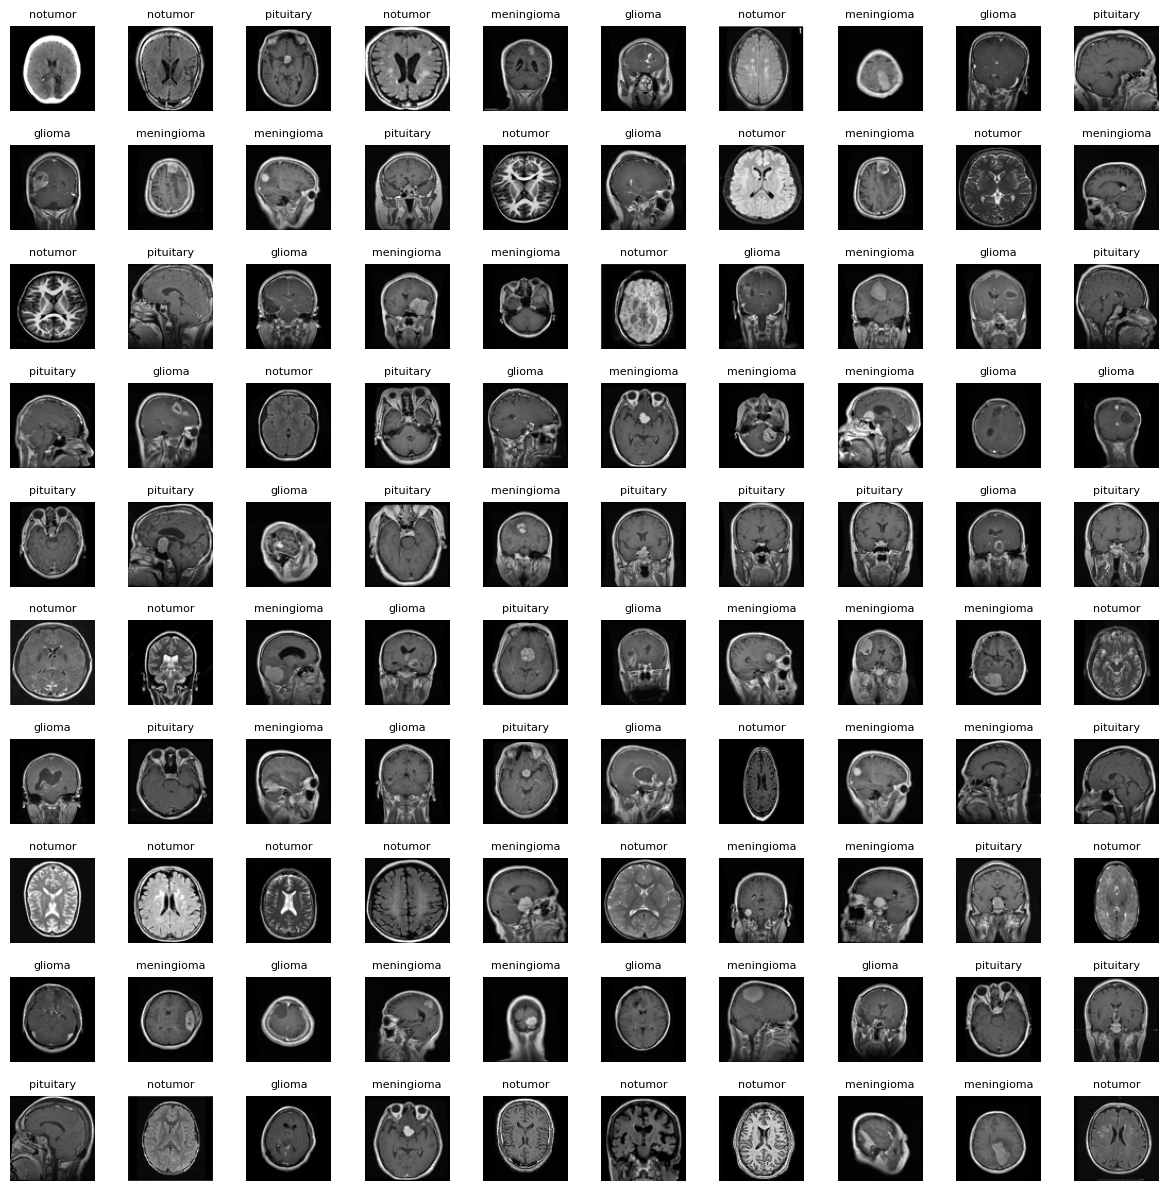

In [10]:
width = 10
height = 10

fig, axes = plt.subplots(height, width, figsize = (15,15))
axes = axes.ravel()
for i in np.arange(0, width * height):
    index = np.random.randint(0, len(X_trains))  
    axes[i].imshow(X_trains[index], cmap = 'gray' )
    axes[i].set_title(y_train.iloc[index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

## **2. Define ground model**

In [29]:
#train autoencoder

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.models import Model

# 입력 정의 (예: 80x80x3 이미지)
input_img = Input(shape=(80, 80, 1))

# --- Encoder ---
x = Conv2D(128, (3, 3), activation='relu', padding='same')(input_img)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)#
x = BatchNormalization()(x)#
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.1)(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)#
x = BatchNormalization()(x)#
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.1)(x)
encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = BatchNormalization(name='encoded_output')(encoded)
#encoded =  MaxPooling2D((2, 2))(encoded)  #뭔가 이상

# --- Decoder ---
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = BatchNormalization()(x)
#x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)#
x = BatchNormalization()(x)#
x = UpSampling2D((2, 2))(x)
x = Dropout(0.1)(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)#
x = BatchNormalization()(x)#
x = UpSampling2D((2, 2))(x)
x = Dropout(0.1)(x)
decoded = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
decoded = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(decoded)  #이상해서 수정

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()
# 비지도 reconstruction 학습
#autoencoder.fit(X_trains, X_trains, epochs=100, batch_size=32)

# 3. Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=100, verbose=1, mode='min', restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_no_aug_autoen.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,  
    patience=10,
    verbose=1, 
    mode='min',
    min_lr=0.00001  
)


Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 80, 80, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 80, 80, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 80, 80, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 80, 80, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 80, 80, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 80, 80, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 80, 80, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 40, 40, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 40, 40, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 40, 40, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 40, 40, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 40, 40, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 40, 40, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 40, 40, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 40, 40, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 20, 20, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoded_output                  │ (None, 20, 20, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 20, 20, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 20, 20, 32)     │           128 │
│ (BatchNormalization)            │                        │             

 Total params: 1,113,569 (4.25 MB)

 Trainable params: 1,111,073 (4.24 MB)

 Non-trainable params: 2,496 (9.75 KB)

In [ ]:
autoencoder.fit(X_trains, X_trains, epochs=120, batch_size=4, validation_data=(X_vals, X_vals), callbacks=[early_stopping, model_checkpoint,reduce_lr])

I0000 00:00:1762946698.836245  210880 service.cc:152] XLA service 0x72175c0172a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762946698.836260  210880 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2025-11-12 20:24:58.847025: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1762946698.925603  210880 cuda_dnn.cc:529] Loaded cuDNN version 90101


21/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

I0000 00:00:1762946699.888951  210880 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


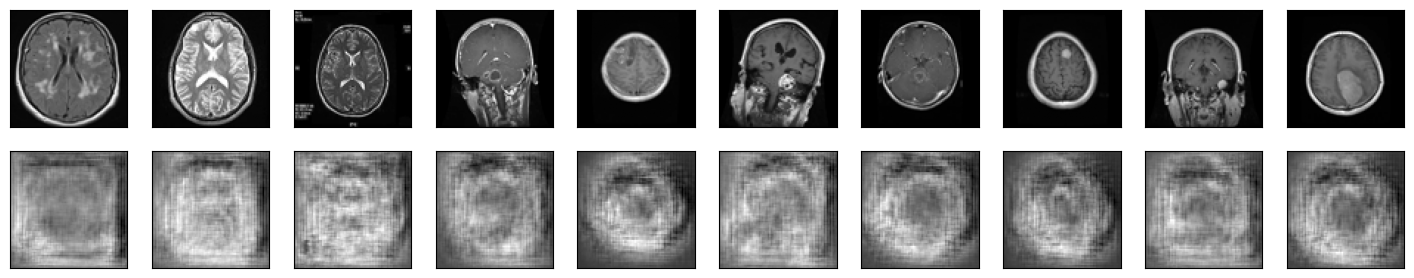

In [12]:
#check performance of autoencoder
decoded_val_images = autoencoder.predict(X_vals)
decoded_test_images = autoencoder.predict(X_tests)

n_images = 10
test_images = np.random.randint(0, X_vals.shape[0], size = n_images)
plt.figure(figsize=(18,18))
for i, image_index in enumerate(test_images):
  # input images
  ax = plt.subplot(10,10, i + 1)
  plt.imshow(X_vals[image_index],cmap='gray')
  plt.xticks(())
  plt.yticks(())

  # Decoded train
  #ax = plt.subplot(10,10, i + 1 + n_images)
  #plt.imshow(coded_test_images[image_index], cmap='gray')
  #plt.xticks(())
  #plt.yticks(())

  # Decoded val
  ax = plt.subplot(10,10, i + 1 + n_images )
  plt.imshow(decoded_val_images[image_index],cmap='gray')
  plt.xticks(())
  plt.yticks(())
  

In [12]:
#train downstream classifier using encoder output

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import GlobalAveragePooling2D, Conv2D, MaxPooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import cv2
import numpy as np
from tensorflow.keras.callbacks import ReduceLROnPlateau

# 1. str type label to int type label
label_encoder = LabelEncoder()
y_int = label_encoder.fit_transform(y_train)
y_val_int = label_encoder.transform(y_val)
y_test_int = label_encoder.fit_transform(y_test)

# 2. int type label to one-hot label
y_onehot = to_categorical(y_int, num_classes=4)
y_val_onehot = to_categorical(y_val_int, num_classes=4)
y_test_onehot = to_categorical(y_test_int, num_classes=4)


print(y_onehot.shape)
print(y_onehot[0])



# extract encoder part to create a new model
encoder_model = Model(inputs=input_img, outputs=encoded)

# CAM-compatible classifier head
x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoder_model.output)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.3)(x)

# Last convolutional layer with 4 filters (for 4 classes)
last_conv_layer = Conv2D(4, (3, 3), activation='relu', padding='same', name='last_conv')(x)

# Global Average Pooling and Dense layer
x = GlobalAveragePooling2D()(last_conv_layer)
out = Dense(4, activation='softmax', name='output_layer')(x)

# 0. model 정의
classifier = Model(inputs=input_img, outputs=out)
# 1. encoder 가중치 freeze
for layer in encoder_model.layers:
    layer.trainable = False

# 2. compile model
optimizer = Adam(learning_rate=0.001)
classifier.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
classifier.summary()

# 3. Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=30, verbose=1, mode='min', restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_classifier_model.keras', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', # 어떤 지표를 관찰할지 지정합니다 (일반적으로 검증 손실 'val_loss')
    factor=0.2,  # 학습률을 얼마나 감소시킬지 지정합니다 (새로운 LR = 기존 LR * factor)
    patience=10, # 이 지표가 몇 epoch 동안 개선되지 않을 때 학습률을 감소시킬지 지정합니다
    verbose=1, # 업데이트 메시지를 표시합니다
    mode='min',# 관찰 지표가 감소해야 개선으로 간주합니다 ('val_loss'의 경우 'min')
    min_lr=0.00001  # 학습률의 최소 하한선을 지정합니다
)

print('fitting done')

(4569, 4)
[0. 1. 0. 0.]


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 80, 80, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 80, 80, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 80, 80, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 80, 80, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 80, 80, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 80, 80, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 80, 80, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 40, 40, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 40, 40, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 40, 40, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 40, 40, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 40, 40, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 40, 40, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 40, 40, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 40, 40, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 20, 20, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 20, 20, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 20, 20, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 20, 20, 64)     │           256 │
│ (BatchNormalization)            │                        │             

 Total params: 560,280 (2.14 MB)

 Trainable params: 76,440 (298.59 KB)

 Non-trainable params: 483,840 (1.85 MB)

fitting done


In [ ]:

history = classifier.fit(X_trains, y_onehot, epochs=80, batch_size=64, validation_data=(X_vals,y_val_onehot), callbacks=[early_stopping, model_checkpoint,reduce_lr])


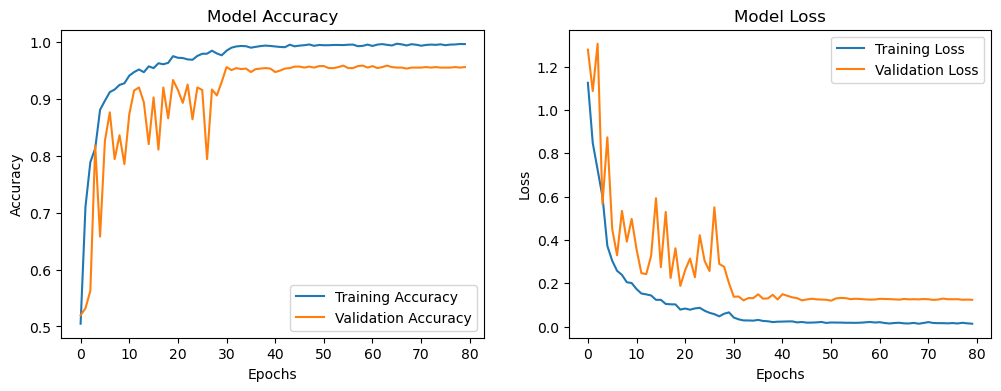

In [31]:

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()




In [14]:
y_test_int

array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
# Load the best model
classifier.load_weights('best_classifier_model.keras')

# CAM Visualization
cam_model = Model(inputs=classifier.input, outputs=(classifier.get_layer('last_conv').output, classifier.output))


#y_test_int = label_encoder.fit_transform(y_test)

# predict
y_pred_prob = classifier.predict(X_tests)  # 클래스별 확률 출력 (num_samples, 4)
y_pred = y_pred_prob.argmax(axis=1)       # 가장 높은 확률 클래스로 변환 (정수 인코딩)


# eval
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

acc = accuracy_score(y_test_int, y_pred)
print(f"Test Accuracy: {acc:.4f}")

# classification report
print(classification_report(y_test_int, y_pred, target_names=label_encoder.classes_))

# confusion matrix(선택사항)
cm = confusion_matrix(y_test_int, y_pred)
print("Confusion Matrix:")
print(cm)

In [ ]:
import random
random.sample(range(1000), 10)

## **3. argumentation, no_freeze, grad_cam**

In [13]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.datasets.fashion_mnist import load_data
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Dropout, Flatten, Dense, GlobalAveragePooling2D,Reshape
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [14]:

X_trains= X_trains.reshape(-1, 80, 80, 1) 
X_tests = X_tests.reshape(-1, 80, 80, 1) 
X_vals = X_vals.reshape(-1, 80, 80, 1) 
print(X_trains.shape, X_tests.shape, X_vals.shape)

(4569, 80, 80, 1) (1311, 80, 80, 1) (1143, 80, 80, 1)


In [30]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


autoencoder_aug = Model(input_img, decoded)
autoencoder_aug.compile(optimizer='adam', loss='mse')
autoencoder_aug.summary()

datagen = ImageDataGenerator(
    rotation_range=15,           # 0~90도 사이 랜덤 회전
    horizontal_flip=True,        # 좌우반전 허용
    vertical_flip=True,      # 상하반전 허용
    zoom_range=0.2           
)

autoencoder_train_generator = datagen.flow(
    X_trains, X_trains,  
    batch_size=4
)


def simple_gen():
    for data, labels in autoencoder_train_generator:
        labels[:] = data
        yield data, labels

# 3. Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=200, verbose=1, mode='min', restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_no_freeze_aug_autoen.keras', monitor='test_loss', verbose=1, save_best_only=False, mode='min')
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', # 어떤 지표를 관찰할지 지정합니다 (일반적으로 검증 손실 'val_loss')
    factor=0.2,  # 학습률을 얼마나 감소시킬지 지정합니다 (새로운 LR = 기존 LR * factor)
    patience=10, # 이 지표가 몇 epoch 동안 개선되지 않을 때 학습률을 감소시킬지 지정합니다
    verbose=1, # 업데이트 메시지를 표시합니다
    mode='min',# 관찰 지표가 감소해야 개선으로 간주합니다 ('val_loss'의 경우 'min')
    min_lr=0.000001  # 학습률의 최소 하한선을 지정합니다
)




Model: "functional_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 80, 80, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 80, 80, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 80, 80, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 80, 80, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 80, 80, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 80, 80, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 80, 80, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 40, 40, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 40, 40, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 40, 40, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 40, 40, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 40, 40, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 40, 40, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 40, 40, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 40, 40, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 20, 20, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoded_output                  │ (None, 20, 20, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 20, 20, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 20, 20, 32)     │           128 │
│ (BatchNormalization)            │                        │             

 Total params: 1,113,569 (4.25 MB)

 Trainable params: 1,111,073 (4.24 MB)

 Non-trainable params: 2,496 (9.75 KB)

In [17]:
# Autoencoder 학습 시 generator 사용 예 (input = output)
autoencoder_aug.fit(
    simple_gen(),
    epochs=250,
    steps_per_epoch=len(X_train) // 4,
    validation_data=(X_vals,X_vals),
    callbacks=[early_stopping, model_checkpoint,reduce_lr]
)

Epoch 1/250
1139/1142 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0196
Epoch 1: val_loss improved from None to 0.00749, saving model to best_no_freeze_aug_autoen.keras
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 0.0098 - val_loss: 0.0075 - learning_rate: 0.0010
Epoch 2/250
1137/1142 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053
Epoch 2: val_loss improved from 0.00749 to 0.00566, saving model to best_no_freeze_aug_autoen.keras
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0050 - val_loss: 0.0057 - learning_rate: 0.0010
Epoch 3/250
1131/1142 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045
Epoch 3: val_loss improved from 0.00566 to 0.00504, saving model to best_no_freeze_aug_autoen.keras
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0044 - val_loss: 0.0050 - learning_rate: 0.0010
Epoch 4/250
1139/1142 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0042
Epoch 4: val_loss did not improve from 0.00504
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0044 - val_loss: 0.

KeyboardInterrupt: 

I0000 00:00:1762949945.461596  224718 service.cc:152] XLA service 0x70ded4027a40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762949945.461613  224718 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2025-11-12 21:19:05.472485: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1762949945.551122  224718 cuda_dnn.cc:529] Loaded cuDNN version 90101


21/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

I0000 00:00:1762949946.521094  224718 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


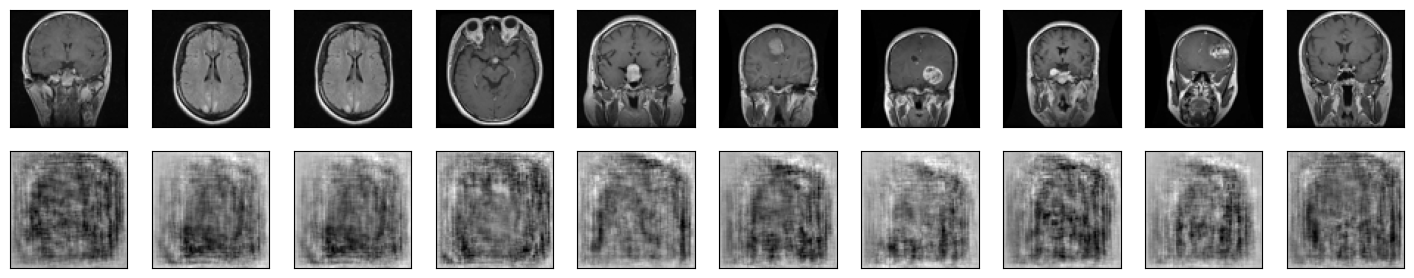

In [16]:
#check performance of autoencoder
decoded_val_images = autoencoder_aug.predict(X_vals)
decoded_test_images = autoencoder_aug.predict(X_tests)

n_images = 10
test_images = np.random.randint(0, X_vals.shape[0], size = n_images)
plt.figure(figsize=(18,18))
for i, image_index in enumerate(test_images):
  # input images
  ax = plt.subplot(10,10, i + 1)
  plt.imshow(X_vals[image_index],cmap='gray')
  plt.xticks(())
  plt.yticks(())

  # Decoded train
  #ax = plt.subplot(10,10, i + 1 + n_images)
  #plt.imshow(coded_test_images[image_index], cmap='gray')
  #plt.xticks(())
  #plt.yticks(())

  # Decoded val
  ax = plt.subplot(10,10, i + 1 + n_images )
  plt.imshow(decoded_val_images[image_index],cmap='gray')
  plt.xticks(())
  plt.yticks(())
  

In [31]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# 예: y_train = ['glioma_tumor', 'pituitary_tumor', ...] (길이 2870)

# 1. 문자열 레이블을 정수 인코딩 (0~3)
label_encoder = LabelEncoder()
y_int = label_encoder.fit_transform(y_train)
y_val_int = label_encoder.transform(y_val)
y_test_int = label_encoder.fit_transform(y_test)

# 2. 정수 레이블을 one-hot 인코딩
y_onehot = to_categorical(y_int, num_classes=4)
y_val_onehot = to_categorical(y_val_int, num_classes=4)
y_test_onehot = to_categorical(y_test_int, num_classes=4)

print(X_tests.shape, y_onehot.shape)  # (2870, 4)
print(y_onehot[0])     # 첫 번째 샘플의 one-hot 벡터 출력


# extract encoder part to create a new model
encoder_model = Model(inputs=input_img, outputs=encoded)

# CAM-compatible classifier head
x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoder_model.output)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)

x = Conv2D(64, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Conv2D(256, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

#x = MaxPooling2D((2, 2))(x)
x = Dropout(0.3)(x)

# Last convolutional layer with 4 filters (for 4 classes)
last_conv_layer = Conv2D(4, (3, 3), activation='relu', padding='same', name='last_conv')(x)

# Global Average Pooling and Dense layer
x = GlobalAveragePooling2D()(last_conv_layer)
out = Dense(4, activation='softmax', name='output_layer')(x)

classifier_aug = Model(inputs=input_img, outputs=out)
# 1. encoder 가중치 freeze
#for layer in encoder_model.layers:
#    layer.trainable = False

optimizer = Adam(learning_rate=0.001)
classifier_aug.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
classifier_aug.summary()


(1311, 80, 80, 1) (4569, 4)
[0. 1. 0. 0.]


Model: "functional_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 80, 80, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 80, 80, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 80, 80, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 80, 80, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 80, 80, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 80, 80, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 80, 80, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 40, 40, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 40, 40, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 40, 40, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 40, 40, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 40, 40, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 40, 40, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 40, 40, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 40, 40, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 20, 20, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoded_output                  │ (None, 20, 20, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 20, 20, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 20, 20, 64)     │           256 │
│ (BatchNormalization)            │                        │             

 Total params: 974,936 (3.72 MB)

 Trainable params: 972,504 (3.71 MB)

 Non-trainable params: 2,432 (9.50 KB)

In [23]:
print(X_trains.shape, X_tests.shape, X_vals.shape)
print(y_onehot.shape, y_val_onehot.shape)

(4569, 80, 80, 1) (1311, 80, 80, 1) (1143, 80, 80, 1)
(4569, 4) (1143, 4)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#X_trains= X_trains.reshape(-1, 80, 80, 1) 
#X_tests = X_trains.reshape(-1, 80, 80, 1) 
#X_vals = X_trains.reshape(-1, 80, 80, 1) 
print(X_trains.shape, X_tests.shape, X_vals.shape)

datagen = ImageDataGenerator(
    rotation_range=15,           # 0~90도 사이 랜덤 회전
    horizontal_flip=True,        # 좌우반전 
    vertical_flip=False           # 상하반전 
)

classifier_train_generator = datagen.flow(
    X_trains, y_onehot,  # 이미지와 레이블(one-hot)
    batch_size=32
)
# 3. Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=80, verbose=1, mode='min', restore_best_weights=True)
model_checkpoint = ModelCheckpoint('no_freeze_best_aug_classifier_model.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', # 어떤 지표를 관찰할지 지정합니다 (일반적으로 검증 손실 'val_loss')
    factor=0.2,  # 학습률을 얼마나 감소시킬지 지정합니다 (새로운 LR = 기존 LR * factor)
    patience=10, # 이 지표가 몇 epoch 동안 개선되지 않을 때 학습률을 감소시킬지 지정합니다
    verbose=1, # 업데이트 메시지를 표시합니다
    mode='min',# 관찰 지표가 감소해야 개선으로 간주합니다 ('val_loss'의 경우 'min')
    min_lr=0.000001  # 학습률의 최소 하한선을 지정합니다
)




(4569, 80, 80, 1) (1311, 80, 80, 1) (1143, 80, 80, 1)
Epoch 1/200


/home/JGY/anaconda3/envs/mri_2025_11/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


139/143 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5753 - loss: 1.2040

KeyboardInterrupt: 

In [ ]:
history = classifier_aug.fit(
    classifier_train_generator, 
    epochs=200, 
    steps_per_epoch= X_trains.shape[0] //32 +1, 
    validation_data= ( X_vals, y_val_onehot),
    callbacks=[early_stopping, model_checkpoint,reduce_lr]
)


In [29]:
# Load the best model
classifier_aug.load_weights('no_freeze_best_aug_classifier_model.keras')

# CAM Visualization
cam_model = Model(inputs=classifier_aug.input, outputs=(classifier_aug.get_layer('last_conv').output, classifier_aug.output))


#y_test_int = label_encoder.fit_transform(y_test)

# predict
y_pred_prob = classifier_aug.predict(X_tests)  # 클래스별 확률 출력 (num_samples, 4)
y_pred = y_pred_prob.argmax(axis=1)       # 가장 높은 확률 클래스로 변환 (정수 인코딩)


# eval
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

acc = accuracy_score(y_test_int, y_pred)
print(f"Test Accuracy: {acc:.4f}")

# classification report
print(classification_report(y_test_int, y_pred, target_names=label_encoder.classes_))

# confusion matrix(선택사항)
cm = confusion_matrix(y_test_int, y_pred)
print("Confusion Matrix:")
print(cm)

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Test Accuracy: 0.9847
              precision    recall  f1-score   support

      glioma       0.99      0.98      0.98       300
  meningioma       0.97      0.96      0.97       306
     notumor       0.98      1.00      0.99       405
   pituitary       1.00      0.99      0.99       300

    accuracy                           0.98      1311
   macro avg       0.99      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311

Confusion Matrix:
[[293   6   1   0]
 [  2 295   8   1]
 [  0   0 405   0]
 [  0   2   0 298]]


/home/JGY/anaconda3/envs/mri_2025_11/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 106 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


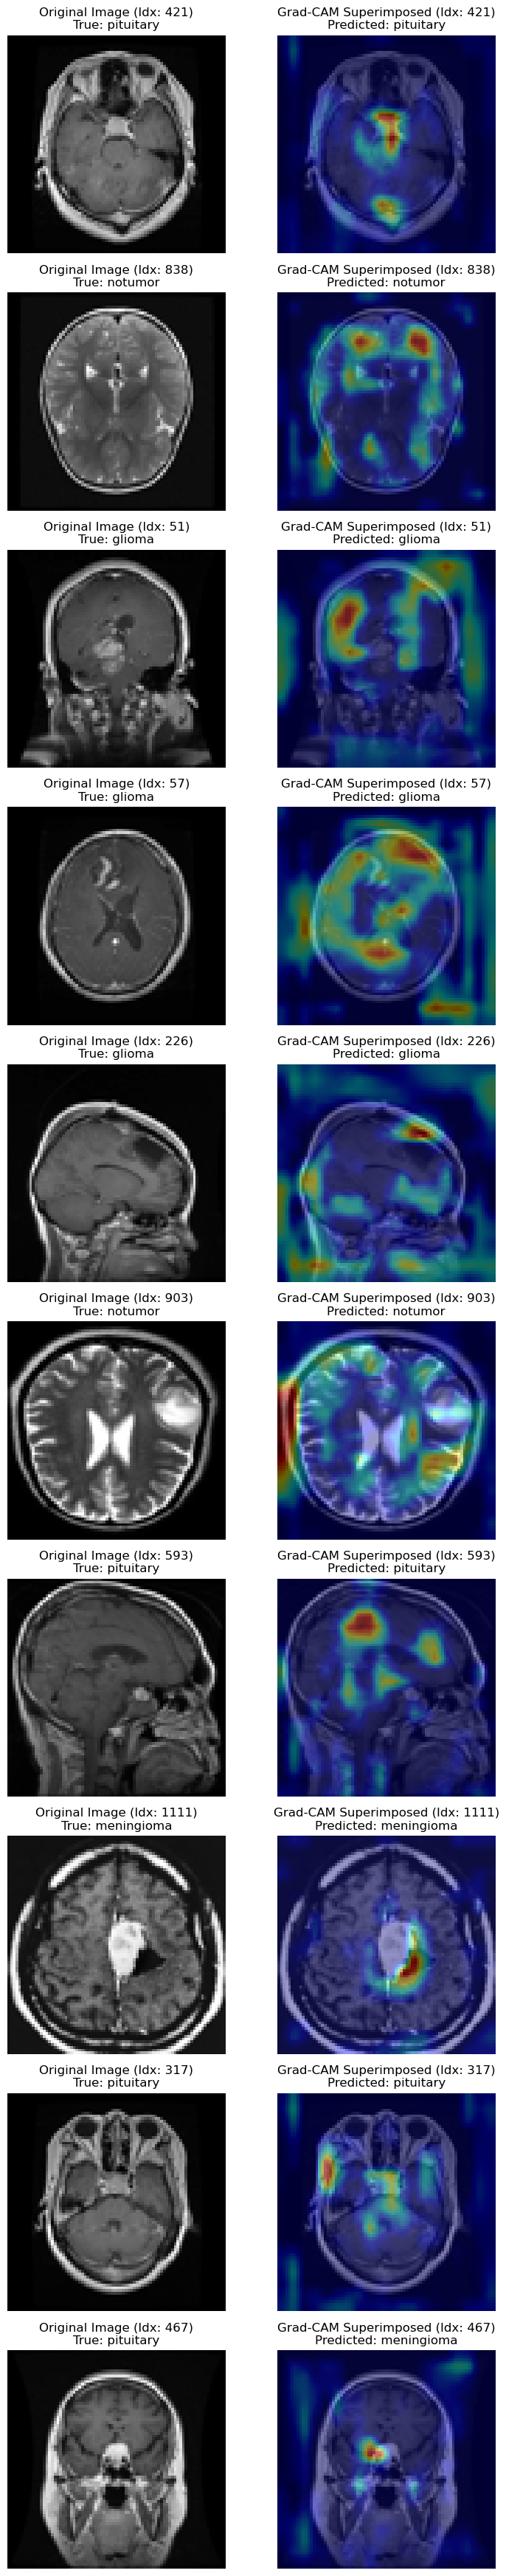

In [60]:
import random
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model # Keras Model 클래스가 필요합니다.
# (matplotlib.pyplot as plt, label_encoder, X_tests, y_test_onehot, classifier_aug 등은 이미 로드되었다고 가정)

# Load the best model
classifier_aug.load_weights('no_freeze_best_aug_classifier_model.keras')

# ==============================================================================
# 💡 Grad-CAM을 위한 변수 설정
# ==============================================================================

# Grad-CAM을 적용할 Conv Layer 이름 설정 (수정 필요)
# 'last_conv'는 CAM 코드에서 사용된 이름입니다. 해당 레이어가 존재하는지 확인하세요.
TARGET_CONV_LAYER_NAME =  'batch_normalization_40'
#'dropout_20'
#Good Layer : 'batch_normalization_40' 

# X_tests 이미지 크기 (수정 필요)
IMAGE_SIZE = 80 
# 이미지 채널 수 (1: 흑백, 3: 컬러)
IMAGE_CHANNELS = 1 
# 출력 채널을 고려하여 BGR로 변환할 때 사용

def get_grad_cam(image_index):
    # 입력 이미지를 텐서로 변환하고 배치 차원 추가
    img_tensor = tf.convert_to_tensor(X_tests[image_index:image_index+1], dtype=tf.float32)

    # Grad-CAM을 위한 새로운 모델 구성:
    # 입력부터 마지막 컨볼루션 레이어까지의 출력과 최종 출력을 모두 반환하는 모델을 정의합니다.
    grad_model = tf.keras.models.Model(
        inputs=classifier_aug.input,
        outputs=[classifier_aug.get_layer(TARGET_CONV_LAYER_NAME).output, classifier_aug.output]
    )

    # 1. GradientTape로 기울기 계산을 추적
    with tf.GradientTape() as tape:
        # 2. 모델 실행: Feature Map (conv_output)과 최종 출력 (preds)을 한 번에 얻습니다.
        #    이때 conv_output은 'Eager Tensor'입니다.
        conv_output, preds = grad_model(img_tensor) 
        
        # conv_output (Eager Tensor)를 감시 목록에 추가
        tape.watch(conv_output)
        
        # 예측된 클래스 인덱스 및 스코어 계산
        # 배치 크기가 1이므로 [0]을 사용
        predicted_class_index = tf.argmax(preds[0])
        
        # 원하는 클래스 c에 대한 스코어 y^c 선택
        class_channel = preds[:, predicted_class_index]

    # 3. 클래스 스코어 y^c에 대한 Feature Map 출력의 기울기 계산
    # grads는 배치 차원 [0]을 제거한 기울기 텐서입니다.
    grads = tape.gradient(class_channel, conv_output)[0]

    # 4. 기울기에 GAP(Global Average Pooling) 적용하여 가중치 알파(alpha) 계산
    # (H, W) 축에 대해 평균을 계산 -> (Channels) 크기의 벡터
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

    # 5. Feature Map과 가중치 알파를 곱하여 Grad-CAM 생성
    # conv_output은 (1, H, W, Channels) 형태이므로 [0]을 사용하여 (H, W, Channels)로 만듭니다.
    last_conv_features = conv_output[0] 
    
    # tf.multiply는 브로드캐스팅을 지원
    heatmap_tensor = tf.reduce_sum(tf.multiply(pooled_grads, last_conv_features), axis=-1)

    # 6. ReLU 적용 및 이후 코드는 동일
    heatmap_tensor = tf.maximum(heatmap_tensor, 0)
    
    # NumPy 배열로 변환
    heatmap = heatmap_tensor.numpy()
    
    # 7. 정규화 및 크기 조정
    if np.max(heatmap) == 0:
        heatmap_normalized = heatmap
    else:
        heatmap_normalized = heatmap / np.max(heatmap)

    # Resize CAM to original image size
    heatmap_resized = cv2.resize(heatmap_normalized, (IMAGE_SIZE, IMAGE_SIZE))
    
    # 8. 히트맵을 원본 이미지에 덧씌우기 (Superimpose)
    # ... (생략: 이전 코드와 동일) ...
    original_image = X_tests[image_index]
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    original_image_uint8 = (original_image * 255).astype('uint8').squeeze()
    
    if IMAGE_CHANNELS == 1:
        original_image_bgr = cv2.cvtColor(original_image_uint8, cv2.COLOR_GRAY2BGR)
    else:
        original_image_bgr = cv2.cvtColor(original_image_uint8, cv2.COLOR_RGB2BGR)
    
    superimposed_img = cv2.addWeighted(original_image_bgr, 0.6, heatmap_colored, 0.4, 0)
    superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
        
    # 9. 레이블 계산 및 반환
    predicted_label = label_encoder.inverse_transform([predicted_class_index.numpy()])[0]
    true_label = label_encoder.inverse_transform([np.argmax(y_test_onehot[image_index])])[0]
    
    return superimposed_img_rgb, original_image, predicted_label, true_label

# X_tests의 길이 내에서 중복 없는 무작위 인덱스 10개 추출
try:
    test_size = len(X_tests)
    # X_tests의 크기가 10개 미만일 경우를 대비하여 min() 사용
    random_indices = random.sample(range(test_size), min(10, test_size)) 
except NameError:
    print("경고: X_tests, label_encoder, y_test_onehot 등이 정의되지 않았습니다. 학습 및 테스트 데이터를 로드하세요.")
    exit()

num_samples = len(random_indices)

# Display N examples (Original vs. Grad-CAM)
fig, axes = plt.subplots(num_samples, 2, figsize=(8, 3.5 * num_samples)) 

# enumerate를 사용하여 i (플롯 행 인덱스: 0~9)와 image_index (데이터 인덱스: 무작위 값)를 분리
for i, image_index in enumerate(random_indices): 
    
    # 1. get_grad_cam 함수 호출
    superimposed_img, original_img, predicted_label, true_label = get_grad_cam(image_index)
    
    # ----------------------------------------
    # Column 1: Original Image
    # ----------------------------------------
    ax_orig = axes[i, 0] # i를 플롯 행 인덱스로 사용 (0부터 시작)
    # 이미지 차원이 (80, 80, 1)일 경우를 대비하여 squeeze() 사용
    ax_orig.imshow(original_img.squeeze(), cmap='gray') 
    ax_orig.set_title(f'Original Image (Idx: {image_index})\nTrue: {true_label}', fontsize=12)
    ax_orig.axis('off')
    
    # ----------------------------------------
    # Column 2: Grad-CAM Image
    # ----------------------------------------
    ax_cam = axes[i, 1] # i를 플롯 행 인덱스로 사용 (0부터 시작)
    # get_grad_cam 함수에서 RGB로 변환하여 반환했으므로 cmap='jet' 불필요
    ax_cam.imshow(superimposed_img) 
    ax_cam.set_title(f'Grad-CAM Superimposed (Idx: {image_index})\nPredicted: {predicted_label}', fontsize=12)
    ax_cam.axis('off')

plt.tight_layout() # 간격 최적화
plt.show() # 결과 출력